In [1]:
import math
from __future__ import division
from collections import OrderedDict
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import histbook as hb

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [2]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [3]:
import fnal_column_analysis_tools.lookup_tools as lookup_tools
import cloudpickle
import zlib

# import a bunch of correction histograms
weightsext = lookup_tools.extractor()
correctionDescriptions = open("newCorrectionFiles.txt").readlines()
weightsext.add_weight_sets(correctionDescriptions)
weightsext.finalize()
weights_eval = weightsext.make_evaluator()
#let's pickle and zip it
weights_names = zlib.compress(cloudpickle.dumps(weightsext._extractor__names))
weights_vals = zlib.compress(cloudpickle.dumps(weightsext._extractor__weights))

#dir(weights_eval)
#print(weights_eval["muScaleFactor_TightId_Iso"])

In [4]:
all_hists = OrderedDict()
cat = hb.groupby("category", keeporder=True)

def add_1d(*args,**kwargs):
    h = None 
    if 'wgt' in kwargs:
        h = hb.Hist(hb.bin(*args), cat, weight=kwargs['wgt'])
    else:
        h = hb.Hist(hb.bin(*args), cat)    
    all_hists[args[0]] = h
    return h


add_1d("stripeThroughput", 300, 0, 1000000)
add_1d("stripeTime", 1000, 0.0, 0.5)
add_1d("leadingLeptonPt", 100, 0, 500,wgt="weight")
add_1d("zMass", 120, 60, 180,wgt="weight")

display_opts = {'width': 300, 'height': 300}
def buildDisplay(hists, cols=2):
    rows = []
    for iRow in range(int(math.ceil(len(hists)/cols))):
        hrowname = hists.keys()[iRow*cols:(iRow+1)*cols]
        hrow = hists.values()[iRow*cols:(iRow+1)*cols]
        rows.append(hb.beside(*tuple(h.overlay("category").step(n, **display_opts) for h,n in zip(hrow, hrowname))))
    return IPythonDisplay(
        hb.below(*tuple(rows))
    )

display = buildDisplay(all_hists)



class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()


In [5]:
#__worker_class__

# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import
    #import subprocess
    #raise Exception(subprocess.check_output("pip list".split(" ")))
    
import numpy as np
import awkward
import uproot_methods
import cloudpickle
import zlib
import time
from collections import OrderedDict
#import fnal_column_analysis_tools
#from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
#from fnal_column_analysis_tools.striped import ColumnGroup, PhysicalColumnGroup
#from fnal_column_analysis_tools.striped.WorkerAddons import Timer
#from fnal_column_analysis_tools.lookup_tools import evaluator

class denselookup(object):
    def __init__(self,values,dims): 
        self.__dimension = 0
        whattype = type(dims)
        if whattype == np.ndarray:
            self.__dimension = 1
        else:
            self.__dimension = len(dims)        
        if self.__dimension == 0:
            raise Exception('Could not define dimension for {}'.format(whattype))
        self.__axes = dims
        self.__values = values
        self.__type = type(self.__values)
    
    def __call__(self,*args):        
        inputs = list(args)
        offsets = None
        # TODO: check can use offsets (this should always be true for striped)
        # Alternatively we can just use starts and stops
        for i in range(len(inputs)):
            if isinstance(inputs[i], awkward.JaggedArray):
                if offsets is not None and offsets.base is not inputs[i].offsets.base:
                    if type(offsets) is int:
                        raise Exception('do not mix JaggedArrays and numpy arrays when calling denselookup')
                    else:
                        raise Exception('All input jagged arrays must have a common structure (offsets)!')
                offsets = inputs[i].offsets
                inputs[i] = inputs[i].content
            elif isinstance(inputs[i], np.ndarray):
                offsets = -1
        retval = self.__evaluate(*tuple(inputs))
        if offsets is not None and type(offsets) is not int:
            retval = awkward.JaggedArray.fromoffsets(offsets,retval)
        return retval
                                               
    
    def __evaluate(self,*args):        
        indices = [] 
        for arg in args: 
            if type(arg) == awkward.JaggedArray: raise Exception('JaggedArray in inputs')
        if self.__dimension == 1:
            indices.append(np.clip(np.searchsorted(self.__axes, args[0], side='right')-1,0,self.__values.shape[0]-1))
        else:
            for dim in range(self.__dimension):
                #print self.__axes[dim], self.__values.shape
                indices.append(np.clip(np.searchsorted(self.__axes[dim], args[dim], side='right')-1,0,self.__values.shape[len(self.__axes)-dim-1]-1))
        indices.reverse()
        return self.__values[tuple(indices)]
    
    def __repr__(self):
        myrepr = "{} dimensional histogram with axes:\n".format(self.__dimension)
        temp = "" 
        if self.__dimension == 1:
            temp = "\t1: {}\n".format(self.__axes)
        else:
            temp = "\t1: {}\n".format(self.__axes[0])
        for idim in range(1,self.__dimension):
            temp += "\t{}: {}\n".format(idim+1,self.__axes[idim])        
        myrepr += temp
        return myrepr

class evaluator(object):
    def __init__(self,names,primitives):
        self.__functions = {}
        for key in names.keys():
            self.__functions[key] = denselookup(*primitives[names[key]])
            
    def __dir__(self):
        return self.__functions.keys()
        
    def __getitem__(self, key):
        return self.__functions[key]

#functions to quickly cash useful quantities
def fast_pt(px,py):
    return np.hypot(px,py)

def fast_eta(px,py,pz):
    p3mag = np.sqrt(px*px + py*py + pz*pz)
    return np.arctanh(pz/p3mag)

def fast_mass(x,y,z,en):
    p3mag2 = (x*x + y*y + z*z)    
    temp = np.abs(en*en - p3mag2)
    return np.sqrt(temp)

def fast_phi(px,py):
    return np.arctan2(py,px)

JaggedTLorentzVectorArray = awkward.Methods.mixin(uproot_methods.classes.TLorentzVector.ArrayMethods, awkward.JaggedArray)

class JaggedCandidateMethods(awkward.Methods):
    
    @classmethod
    def candidatesfromcounts(cls,counts,p4,**kwargs):
        items = {}
        if isinstance(p4,uproot_methods.TLorentzVectorArray):
            items['p4'] = p4
        else:
            items['p4'] = uproot_methods.TLorentzVectorArray(p4[:,0],p4[:,1],
                                                             p4[:,2],p4[:,3])
        thep4 = items['p4']
        items['__fast_mass'] = fast_mass(thep4.x,thep4.y,thep4.z,thep4.t)
        items['__fast_pt'] = fast_pt(thep4.x,thep4.y)
        items['__fast_eta'] = fast_eta(thep4.x,thep4.y,thep4.z)
        items['__fast_phi'] = fast_phi(thep4.x,thep4.y)
        items.update(kwargs)
        return cls.fromcounts(counts,awkward.Table(items))
    
    @property
    def p4(self):
        return self['p4']
    
    @property
    def mass(self):
        return self['__fast_mass']

    @property
    def pt(self):
        return self['__fast_pt']

    @property
    def eta(self):
        return self['__fast_eta']

    @property
    def phi(self):
        return self['__fast_phi']

    def at(self,what):
        thewhat = super(JaggedCandidateMethods,self).at(what)
        if 'p4' in thewhat.columns:
            return self.fromjagged(thewhat)
        return thewhat
    
    def distincts(self):
        return self.pairs(same=False)
    
    def pairs(self, same=True):
        outs = super(JaggedCandidateMethods, self).pairs(same)
        thep4 = outs.at(0)['p4'] + outs.at(1)['p4']
        p4content = thep4.content
        outs['p4'] = thep4
        outs['__fast_mass'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_mass(p4content.x,
                                                                                    p4content.y,
                                                                                    p4content.z,
                                                                                    p4content.t))
        outs['__fast_pt'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_pt(p4content.x,
                                                                                p4content.y))
        outs['__fast_eta'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_eta(p4content.x,
                                                                                  p4content.y,
                                                                                  p4content.z))
        outs['__fast_phi'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_phi(p4content.x,
                                                                                  p4content.y))
        return self.fromjagged(outs)
    
    def cross(self, other):
        outs = super(JaggedCandidateMethods, self).cross(other)
        #currently JaggedArray.cross() has some funny behavior when it encounters the
        # p4 column and makes some wierd new column... for now I just delete it and reorder
        # everything looks ok after that
        keys = outs.columns
        reorder = False
        for key in keys:
            if not isinstance(outs[key].content,awkward.array.table.Table):
                del outs[key]
                reorder = True
        if reorder:
            keys = outs.columns
            realkey = {}
            for i in xrange(len(keys)):
                realkey[keys[i]] = str(i)
            for key in keys:
                if realkey[key] != key:
                    outs[realkey[key]] = outs[key]
                    del outs[key]
        keys = outs.columns
        for key in keys:
            if 'p4' not in outs.columns:
                outs['p4'] = outs.at(int(key))['p4']
            else:
                outs['p4'] = outs['p4'] + outs.at(int(key))['p4']
        thep4 = outs['p4']
        p4content = thep4.content
        outs['__fast_mass'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_mass(p4content.x,
                                                                                    p4content.y,
                                                                                    p4content.z,
                                                                                    p4content.t))
        outs['__fast_pt'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_pt(p4content.x,
                                                                                p4content.y))
        outs['__fast_eta'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_eta(p4content.x,
                                                                                  p4content.y,
                                                                                  p4content.z))
        outs['__fast_phi'] = awkward.JaggedArray.fromcounts(thep4.counts,fast_phi(p4content.x,
                                                                                  p4content.y))
        return self.fromjagged(outs)

    def __getattr__(self,what):
        if what in self.columns:
            return self[what]
        return getattr(super(JaggedCandidateMethods,self),what)

JaggedCandidateArray = awkward.Methods.mixin(JaggedCandidateMethods, awkward.JaggedArray)

class ColumnGroup(object):
    def __init__(self,events,objName,*args):
        self.__map = {}        
        eventObj = getattr(events,objName)
        self.__counts = getattr(events,objName).count        
        for arg in args:
            callStack = arg.split('.')
            retval = getattr(eventObj,callStack[0])
            for i in range(1,len(callStack)):
                retval = getattr(retval,callStack[i])
            self.__map[arg] = retval
            
    def __getitem__(self,name):
        return self.__map[name]
    
    def columnsWithout(self,toremove):
        out = {}
        out.update(self.__map)
        if isinstance(toremove,str):
            del out[toremove]
        else:
            for key in toremove:
                del out[key]
        return out
    
    def columns(self):
        return self.__map
    
    def counts(self):
        return self.__counts
    
class PhysicalColumnGroup(ColumnGroup):
    def __init__(self,events,objName,p4Name,*args):
        self.__p4  = p4Name
        allargs = [p4Name]
        allargs.extend(args)        
        super(PhysicalColumnGroup,self).__init__(events,objName,*allargs)
        if p4Name is not None:
            self.setP4Name(p4Name)
    
    def setP4Name(self,name):
        if name not in self.columns().keys():
            raise Exception('{} not an available name in this PhysicalColumnGroup'.format(name))
        self.__p4 = name
    
    def p4Name(self):
        if self.__p4 is None:
            raise Exception('p4 is not set for this PhysicalColumnGroup')
        return self.__p4
    
    def p4Column(self):        
        return self[self.p4Name()]
    
    def otherColumns(self):
        return self.columnsWithout(self.p4Name())

def jaggedFromColumnGroup(cgroup):
    if isinstance(cgroup,PhysicalColumnGroup):
        return JaggedCandidateArray.candidatesfromcounts(counts = cgroup.counts(),
                                                         p4 = cgroup.p4Column(),
                                                         **cgroup.otherColumns())
    else:
        return awkward.JaggedArray.fromcounts(cgroup.counts(),
                                              awkward.Table(cgroup.columns()))

class Timer(object):
    def __init__(self):
        self.__tic = {}
        self.__toc = {}

    def set_tic(self,name):
        self.__tic[name] = time.time()

    def set_toc(self,name):
        self.__toc[name] = time.time()

    def get_tic(self,name):
        return self.__tic[name]

    def get_toc(self,name):
        return self.__toc[name]

    def tics(self):
        return self.__tic

    def tocs(self):
        return self.__toc
    
    def fill_job_timer_info(self,stripelen,job):
        tic = self.__tic
        toc = self.__toc
        for key in tic.keys():
            dtime = toc[key]-tic[key]
            job.fill(
                category=key,
                stripeThroughput=stripelen/(dtime+1e-8),
                stripeTime=dtime
            )
    
class Worker(Timer):
    def __init__(self):
        super(Worker,self).__init__()
        self.Columns = ["Electron.charge", "Electron.p4", "Electron.tightID",
                        "Muon.charge", "Muon.p4", "Muon.tightID",
                        "Trigger.pass"]
        self.weights_eval = None
    
    def run(self, events, job):
        stripelen = len(events.Muon.count)
        self.set_tic('all')
        
        if self.weights_eval is None:            
            self.weights_eval = evaluator(cloudpickle.loads(zlib.decompress(job["weights_names"])),
                                          cloudpickle.loads(zlib.decompress(job["weights_vals"])))
        weights_eval = self.weights_eval
        
        #35: HLT_Ele32_WPTight_Gsf_v
        #36: HLT_Ele35_WPTight_Gsf_v
        #45: HLT_IsoMu20_v
        #46: HLT_IsoMu22_v
        #48: HLT_IsoMu24_v
        #50: HLT_IsoMu27_v
        # yes, this is trivial for now but perhaps it's more fun later
        triggerColumns = ColumnGroup(events,"Trigger","pass")
        triggers = jaggedFromColumnGroup(triggerColumns)
        
        #only care about processing events which have triggered
        events_triggered = ( (triggers["pass"][:,35] > 0) |
                             (triggers["pass"][:,36] > 0) |
                             (triggers["pass"][:,45] > 0) |   
                             (triggers["pass"][:,46] > 0) |
                             (triggers["pass"][:,48] > 0) |
                             (triggers["pass"][:,50] > 0)   )
        
        electronCols = PhysicalColumnGroup(events,"Electron","p4","charge","tightID")
        electrons_new = jaggedFromColumnGroup(electronCols)                
        
        muonCols = PhysicalColumnGroup(events,"Muon","p4","charge","tightID")
        muons_new = jaggedFromColumnGroup(muonCols)                

        electrons_new['SF'] = weights_eval["eleScaleFactor_TightId_POG"](electrons_new.eta,
                                                                         electrons_new.pt)
        muons_new['SF'] = weights_eval["muScaleFactor_TightId_Iso"](np.absolute(muons_new.eta),
                                                                    muons_new.pt)

        electrons_trig = electrons_new#[events_triggered] 
        muons_trig = muons_new#[events_triggered]

        electron_selection = ( (electrons_trig.pt > 20) &
                               (np.abs(electrons_trig.eta) < 2.5) &
                               (electrons_trig.tightID > 0) )
        muon_selection = ( (muons_trig.pt > 20) &
                           (np.abs(muons_trig.eta) < 2.4) &
                           (muons_trig.tightID > 0) )

        selected_electrons = electrons_trig[electron_selection]        
        selected_muons = muons_trig[muon_selection]

        dielectrons = selected_electrons.distincts()
        dimuons = selected_muons.distincts()

        selected_dielectrons = dielectrons[((dielectrons.at(0).pt > 38) | (dielectrons.at(1).pt > 38))] 
        selected_dimuons = dimuons[((dimuons.at(0).pt > 30) | (dimuons.at(1).pt > 30))]

        zee_cat = ((selected_dielectrons.counts == 1) & 
                   (selected_dimuons.counts == 0))
        #fill electrons
        SF1e = selected_dielectrons[zee_cat].at(0).SF
        SF2e = selected_dielectrons[zee_cat].at(1).SF
        job.fill(
            category="ee",
            leadingLeptonPt=np.maximum(selected_dielectrons[zee_cat].at(0).pt,
                                       selected_dielectrons[zee_cat].at(1).pt).flatten(),
            zMass=selected_dielectrons[zee_cat].mass.flatten(),
            weight=(SF1e*SF2e).flatten()
        )            
            
        zmm_cat = ((selected_dimuons.counts == 1) & 
                   (selected_dielectrons.counts == 0))
        SF1mu = selected_dimuons[zmm_cat].at(0).SF
        SF2mu = selected_dimuons[zmm_cat].at(1).SF
        #fill muons
        job.fill(
            category="mm",
            leadingLeptonPt=np.maximum(selected_dimuons[zmm_cat].at(0).pt,
                                        selected_dimuons[zmm_cat].at(1).pt).flatten(),
            zMass=selected_dimuons[zmm_cat].mass.flatten(),
            weight=(SF1mu*SF2mu).flatten()
        ) 
                
        #fill both
        #job.fill(
        #    category="all",
        #    leadingLeptonPt=np.hstack([np.maximum(selected_dimuons[zmm_cat].at(0).p4.pt,
        #                                          selected_dimuons[zmm_cat].at(1).p4.pt).flatten(), 
        #                               np.maximum(selected_dielectrons[zee_cat].at(0).p4.pt,
        #                                          selected_dielectrons[zee_cat].at(1).p4.pt).flatten()]),
        #)
        #job.fill(
        #    category="all",            
        #    zMass=np.hstack([selected_dielectrons[zee_cat].p4.mass.flatten(), 
        #                     selected_dimuons[zmm_cat].p4.mass.flatten()])
        #)
        
        #profiling info
        self.set_toc('all')
        self.fill_job_timer_info(stripelen,job)        
        

Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8         45.014 M events,   7.220 M events/sec


Total events processed: 45013666 in 15.1 seconds -> 2.985001 million events/second


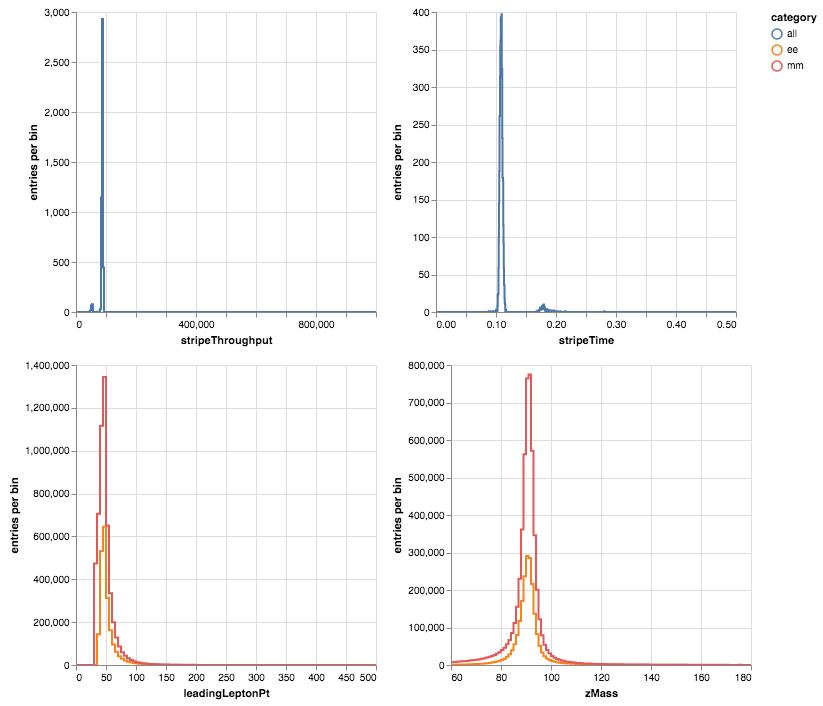

In [6]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists.values())

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=1.,
            user_callback=callback, 
            user_params = {"weights_names":weights_names,
                           "weights_vals":weights_vals},
            histograms=all_hists.values()
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)


In [7]:
def moment(df, n, binval='mid'):
    """
        df: DataFrame with single-level MultiIndex specifying binning, and a shape of (nbins, )
        n: n-th moment of distribution, ignoring (over/under/nan)flow bins
        binval in ['left', 'right', 'mid']: point in the bin to use as bin value
    """
    vals = np.array([getattr(b, binval) for b in df.index if type(b) is not str])[1:-1]
    weights = np.array(df)[1:-2]  # ignore nanflow (last bin)
    moment = sum(pow(vals, n)*weights) / sum(weights)
    return moment

def mean(df, binval='mid'):
    return moment(df, 1, binval)

def std(df, binval='mid'):
    return np.sqrt(max(moment(df, 2, binval) - moment(df, 1, binval)**2, 0.))

In [8]:
stripeThroughput = mean(all_hists['stripeThroughput'].pandas()['count()']["all"])
nWorkers = 180
processingTime = nevents_total/stripeThroughput/nWorkers
print "Stripe processing throughput: %.0f evt/s" % stripeThroughput
print "Total throughput: %.0f evt/s" % (nevents_total/(t2-t1), )
print "Striped server overhead: %.1f %%" % ((1-processingTime/(t2-t1))*100, )

Stripe processing throughput: 86531 evt/s
Total throughput: 2985001 evt/s
Striped server overhead: 80.8 %
